In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import math
from skimage.metrics import structural_similarity as ssim

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
else:
    print("No NVDIA driver found. Using CPU")

0


In [31]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


class ColorizationNet(nn.Module):
  def __init__(self):
    super(ColorizationNet,self).__init__()
    self.conv1 = nn.Conv2d(1,64,kernel_size = 5,stride = 1, padding = 4,dilation =2)
    self.conv2 = nn.Conv2d(64,64,kernel_size = 5,stride = 1, padding = 4,dilation =2)
    self.conv3 = nn.Conv2d(64,128,kernel_size = 5,stride = 1, padding = 4,dilation =2)
    self.conv4 = nn.Conv2d(128,3,kernel_size = 5,stride = 1, padding = 4,dilation =2)

  def forward(self,x):
    x=nn.functional.relu(self.conv1(x))
    x=nn.functional.relu(self.conv2(x))
    x=nn.functional.relu(self.conv3(x))
    x=torch.sigmoid(self.conv4(x))

    return x

In [33]:
criterion = nn.MSELoss()

def rgb_to_gray(img):
  return img.mean(dim=1, keepdim=True)

In [34]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]

In [35]:
# PSNR Calculation
def calculate_psnr(output, target):
    mse = F.mse_loss(output, target).item()
    if mse == 0: 
        return 100  # Avoid division by zero
    return 20 * math.log10(1.0 / math.sqrt(mse))

# SSIM Calculation
def calculate_ssim(output, target):
    # Remove the batch dimension if it exists
    output_np = output.squeeze().cpu().numpy()
    target_np = target.squeeze().cpu().numpy()

    # Check if the output has 3 channels (RGB) or just 1 (Grayscale)
    if output_np.ndim == 3:  # For RGB images
        output_np = output_np.transpose(1, 2, 0)
        target_np = target_np.transpose(1, 2, 0)
    
    # Compute SSIM, assuming the images are normalized between 0 and 1
    return ssim(output_np, target_np, multichannel=(output_np.ndim == 3), data_range=1.0, win_size=3)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
	img = img/2 +0.5
	npimg = img.numpy()

	if len(img.shape) == 2:
		plt.imshow(npimg,cmap = 'gray')
	else:
		plt.imshow(np.transpose(npimg,(1,2,0)))

def visualize_all_three(original_images,grayscale_images,colorized_images,n=5):
	fig =plt.figure(figsize =(3*n,4))
	for i in range(n):
		ax = plt.subplot(1,3*n,3*i+1)
		imshow(original_images[i])
		ax.set_title("Original")
		ax.axis("off")

		ax = plt.subplot(1,3*n,3*i+2)
		imshow(grayscale_images[i])
		ax.set_title("Grayscale")
		ax.axis("off")

		ax = plt.subplot(1,3*n,3*i+3)
		imshow(colorized_images[i])
		ax.set_title("Colorized")
		ax.axis("off")

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [37]:
def torch_rgb_to_hsv(rgb):
	r,g,b = rgb[:,0,:,:],rgb[:,1,:,:],rgb[:,2,:,:]
	max_val, _ = torch.max(rgb,dim =1)
	min_val, _ = torch.min(rgb,dim=1)

	diff = max_val - min_val
	h=torch.zeros_like(r)
	mask = (max_val ==r) &(g>=b)
	h[mask] =(g[mask] - b[mask])/diff[mask]
	mask = (max_val ==r) &(g<b)
	h[mask] =(g[mask] - b[mask])/diff[mask] + 6.0
	mask = max_val == g
	h[mask] =(g[mask] - r[mask])/diff[mask] + 4.0
	h=h/6.0
	h[diff == 0.0] =0.0

	s=torch.zeros_like(r)
	s[diff!=0.0] = diff[diff != 0.0]/max_val[diff != 0.0]

	v=max_val

	return torch.stack([h,s,v],dim=1)

In [38]:
def torch_hsv_to_rgb(hsv):
	h,s,v = hsv[:,0,:,:],hsv[:,1,:,:],hsv[:,2,:,:]
	i= torch.floor(h * 6.0).int()
	f=h*6.0-i
	p= v* (1.0 -s)
	q = v*(1.0 - s*f)
	t = v* (1.0 -s*(1.0 -f))

	i_mod = i%6
	r=torch.zeros_like(h)
	g=torch.zeros_like(h)
	b=torch.zeros_like(h)

	r[i_mod == 0.0] = v[i_mod == 0.0]
	g[i_mod == 0.0] = t[i_mod == 0.0]
	b[i_mod == 0.0] = p[i_mod == 0.0]

	r[i_mod == 1.0] = q[i_mod == 1.0]
	g[i_mod == 1.0] = v[i_mod == 1.0]
	b[i_mod == 1.0] = p[i_mod == 1.0]

	r[i_mod == 2.0] = p[i_mod == 2.0]
	g[i_mod == 2.0] = v[i_mod == 2.0]
	b[i_mod == 2.0] = t[i_mod == 2.0]

	r[i_mod == 3.0] = p[i_mod == 3.0]
	g[i_mod == 3.0] = q[i_mod == 3.0]
	b[i_mod == 3.0] = v[i_mod == 3.0]

	r[i_mod == 4.0] = t[i_mod == 4.0]
	g[i_mod == 4.0] = p[i_mod == 4.0]
	b[i_mod == 4.0] = v[i_mod == 4.0]

	r[i_mod == 5.0] = v[i_mod == 5.0]
	g[i_mod == 5.0] = p[i_mod == 5.0]
	b[i_mod == 5.0] = q[i_mod == 5.0]

	return torch.stack([r,g,b],dim=1)

In [39]:
def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    # Normalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Adjust the saturation and value channels separately
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)  # Saturation
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)  # Value (brightness)

    # Convert back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert back from [0, 1] to [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images

In [40]:
# Function to plot graphs for training loss
def plot_training_loss(training_losses):
    # Generate a unique filename for the training loss plot
    filename = f"training_loss_{int(time.time())}.png"
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # Save the plot as a PNG file with the unique filename
    plt.savefig(filename)
    plt.show()
    
    print(f"Training loss plot saved as {filename}")

In [41]:
# Function to calculate accuracy
def calculate_accuracy(output, target):
    output_np = (output > 0.5).float().cpu().numpy()  # Threshold at 0.5 to convert to binary prediction
    target_np = target.cpu().numpy()
    accuracy = (output_np == target_np).mean() * 100
    return accuracy

In [42]:
def calculate_image_wise_accuracy(output, target):
    # Threshold at 0.5 to convert to binary prediction
    output_np = (output > 0.5).float().cpu().numpy()
    target_np = target.cpu().numpy()

    # Check if entire images are the same (True if all pixels match)
    correct_images = np.all(output_np == target_np, axis=(1, 2, 3))  # Shape is [batch_size, height, width, channels]
    
    # Calculate the percentage of images that were correct
    image_wise_accuracy = correct_images.mean() * 100
    return image_wise_accuracy

In [43]:
# Function to plot training and validation loss
def plot_loss(training_losses, validation_losses, lr, batch_size):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss (LR={lr}, Batch Size={batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

In [44]:
# Function to plot training and validation accuracy
def plot_accuracy(training_accuracies, validation_accuracies, lr, batch_size):
    plt.figure(figsize=(10, 5))
    plt.plot(training_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (LR={lr}, Batch Size={batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

In [45]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [46]:
from torch.utils.data import random_split

# Assume train_dataset is already defined
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [47]:
import time

# Function to train the model
def train_model(model, optimizer, train_loader, lr, batch_size, EPOCHS=30, val_loader=None):
    model.train()
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    psnr_values = []
    ssim_values = []

    for epoch in range(EPOCHS):  
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for i, (images, _) in enumerate(train_loader):
            grayscale_images = rgb_to_gray(images).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(grayscale_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compare the outputs and ground truth images directly for pixel-wise accuracy
            outputs_binary = (outputs > 0.5).float()
            images_binary = (images > 0.5).float()

            correct_train += (outputs_binary == images_binary).sum().item()
            total_train += images.numel()
            
            if i % 100 == 0:  
                print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(train_loader)}], "
                      f"Loss: {running_loss / (i+1):.4f}, ")
            
            # Store the last outputs and images after processing the last batch
            last_outputs = outputs
            last_images = images

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        training_losses.append(avg_train_loss)
        training_accuracies.append(train_accuracy)
        
        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{EPOCHS}] completed in {epoch_time:.2f} seconds, "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Evaluate the model after every epoch
        if val_loader:
            avg_val_loss, val_accuracy, avg_psnr, avg_ssim, accuracy_list, precision_list, recall_list, cm_list, last_outputs, last_images = evaluate_model_epoch(model, val_loader)
            validation_losses.append(avg_val_loss)
            validation_accuracies.append(val_accuracy)
            psnr_values.append(avg_psnr)
            ssim_values.append(avg_ssim)

    return training_losses, training_accuracies, validation_losses, validation_accuracies, psnr_values, ssim_values, last_outputs, last_images

In [48]:
# Function to evaluate the model during each epoch
def evaluate_model_epoch(model, val_loader):
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    psnr_total = 0
    ssim_total = 0

    accuracy_list = []
    precision_list = []
    recall_list = []
    cm_list = []

    with torch.no_grad():
        for i, (images, _) in enumerate(val_loader):
            grayscale_images = rgb_to_gray(images).to(device)
            images = images.to(device)

            outputs = model(grayscale_images)
            
            # Store the last batch of outputs and images
            last_outputs = outputs
            last_images = images
            
            # Call the exaggerate_colors function here to apply the effect
            exaggerated_outputs = exaggerate_colors(outputs)

            # Threshold the outputs and target images to binary
            outputs_binary = (outputs > 0.5).float()
            images_binary = (images > 0.5).float()

            # Validation loss and accuracy
            val_loss = criterion(outputs, images)
            val_running_loss += val_loss.item()
            correct_val += (outputs_binary == images_binary).sum().item()
            total_val += images.numel()

            # Accuracy
            accuracy = calculate_accuracy(outputs_binary, images_binary)
            accuracy_list.append(accuracy)

            # Flatten the outputs and ground truth images for metric calculation
            output_np = outputs_binary.cpu().numpy().flatten()
            target_np = images_binary.cpu().numpy().flatten()

            # Precision and Recall (using binary values)
            precision = precision_score(target_np, output_np, average='macro')
            recall = recall_score(target_np, output_np, average='macro')
            precision_list.append(precision)
            recall_list.append(recall)
            
            # Calculate PSNR and SSIM
            psnr_total += calculate_psnr(outputs, images)
            ssim_total += calculate_ssim(outputs, images)
            
            # Confusion Matrix
            cm = confusion_matrix(target_np, output_np)
            cm_list.append(cm)

        # Calculate averages across the validation dataset
        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        avg_psnr = psnr_total / len(val_loader)
        avg_ssim = ssim_total / len(val_loader)

        # Print validation metrics
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
              f"PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    # Return all calculated metrics
    return avg_val_loss, val_accuracy, avg_psnr, avg_ssim, accuracy_list, precision_list, recall_list, cm_list, last_outputs, last_images

In [49]:
# Function to train and evaluate the model with given hyperparameters
def train_and_evaluate_model(lr, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ColorizationNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train and evaluate the model
    training_losses, training_accuracies, validation_losses, validation_accuracies, psnr_values, ssim_values,last_outputs, last_images = train_model(
        model, optimizer, train_loader, lr, batch_size, val_loader=val_loader)

    # After all epochs
    print(f"Training complete! Best Validation Accuracy: {max(validation_accuracies):.4f}")
    
    # Visualization code should be added here
    colorized_images_cpu = last_outputs.cpu()  # Get the last outputs
    original_images_cpu = last_images.cpu()     # Get the last images
    grayscale_images_cpu = rgb_to_gray(original_images_cpu).cpu().squeeze(1)

    # Visualize the images
    visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu, n=5)

    # Generate a unique filename before saving the plot
    filename = f"colorization_output_{int(time.time())}.png"

    # Save the image file
    plt.savefig(filename)
    print(f"Output image saved as {filename}")
    
    # Final evaluations and plots after all epochs
    outputs_binary = (last_outputs > 0.5).float()  # Use the last outputs from the final epoch
    images_binary = (last_images > 0.5).float()      # Use the last images from the final epoch

    # Flatten the arrays to make them compatible with precision_score and recall_score
    outputs_flat = outputs_binary.cpu().numpy().flatten()
    images_flat = images_binary.cpu().numpy().flatten()

    avg_accuracy = calculate_accuracy(outputs_binary, images_binary)
    
    # Calculate precision and recall
    avg_precision = precision_score(images_flat, outputs_flat, average='macro')
    avg_recall = recall_score(images_flat, outputs_flat, average='macro')
    
    print(f"Final Model with LR={lr}, Batch Size={batch_size}:")
    print(f"Accuracy: {avg_accuracy:.2f}%, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}")

    image_wise_accuracy = calculate_image_wise_accuracy(outputs_binary, images_binary)
    print(f"Image-wise Accuracy: {image_wise_accuracy:.2f}%")

    # Plot Confusion Matrix
    avg_cm = confusion_matrix(images_flat, outputs_flat)
    plot_confusion_matrix(avg_cm, labels=['0', '1'], title=f'Confusion Matrix (LR={lr}, Batch Size={batch_size})')

    # Plot the training and validation losses and accuracies after all epochs
    plot_loss(training_losses, validation_losses, lr, batch_size)
    plot_accuracy(training_accuracies, validation_accuracies, lr, batch_size)



Training with Learning Rate: 0.001, Batch Size: 32
Epoch [1/30], Batch [1/1250], Loss: 0.5498, 
Epoch [1/30], Batch [101/1250], Loss: 0.2075, 
Epoch [1/30], Batch [201/1250], Loss: 0.1851, 
Epoch [1/30], Batch [301/1250], Loss: 0.1754, 
Epoch [1/30], Batch [401/1250], Loss: 0.1697, 
Epoch [1/30], Batch [501/1250], Loss: 0.1668, 
Epoch [1/30], Batch [601/1250], Loss: 0.1645, 
Epoch [1/30], Batch [701/1250], Loss: 0.1622, 
Epoch [1/30], Batch [801/1250], Loss: 0.1607, 
Epoch [1/30], Batch [901/1250], Loss: 0.1595, 
Epoch [1/30], Batch [1001/1250], Loss: 0.1587, 
Epoch [1/30], Batch [1101/1250], Loss: 0.1582, 
Epoch [1/30], Batch [1201/1250], Loss: 0.1579, 
Epoch [1/30] completed in 34.74 seconds, Train Loss: 0.1578, Train Accuracy: 0.9457
Validation Loss: 0.1507, Validation Accuracy: 0.9556, PSNR: 8.25, SSIM: 0.0889
Epoch [2/30], Batch [1/1250], Loss: 0.1563, 
Epoch [2/30], Batch [101/1250], Loss: 0.1489, 
Epoch [2/30], Batch [201/1250], Loss: 0.1501, 
Epoch [2/30], Batch [301/1250], Lo

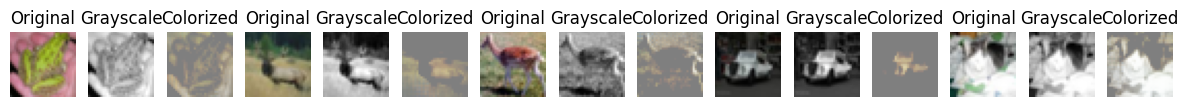

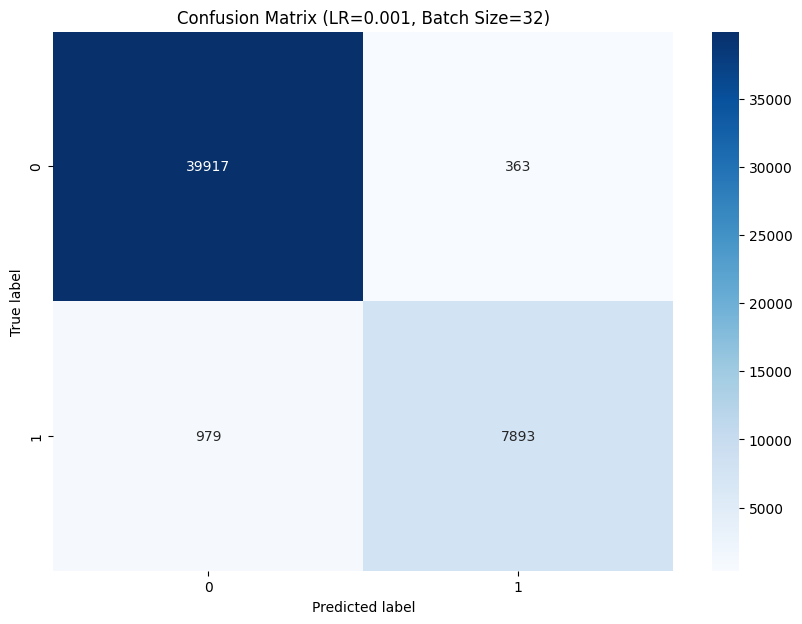

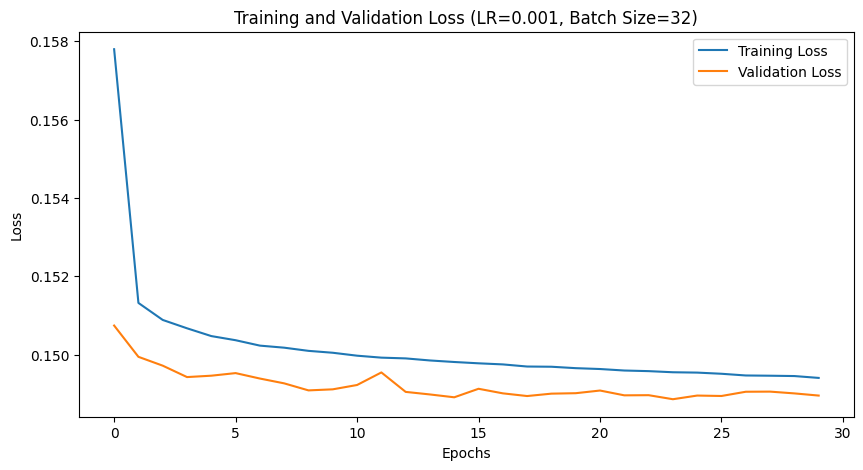

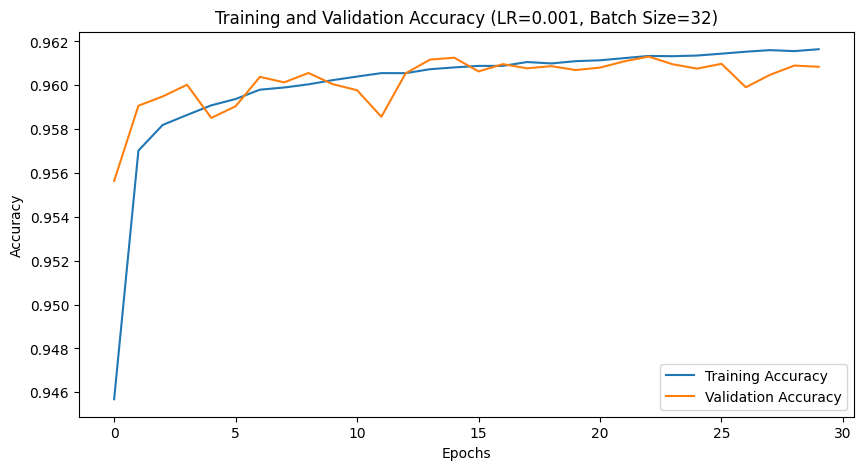


Training with Learning Rate: 0.001, Batch Size: 64
Epoch [1/30], Batch [1/625], Loss: 0.5611, 
Epoch [1/30], Batch [101/625], Loss: 0.2082, 
Epoch [1/30], Batch [201/625], Loss: 0.1854, 
Epoch [1/30], Batch [301/625], Loss: 0.1754, 
Epoch [1/30], Batch [401/625], Loss: 0.1702, 
Epoch [1/30], Batch [501/625], Loss: 0.1664, 
Epoch [1/30], Batch [601/625], Loss: 0.1641, 
Epoch [1/30] completed in 33.78 seconds, Train Loss: 0.1637, Train Accuracy: 0.9351
Validation Loss: 0.1512, Validation Accuracy: 0.9556, PSNR: 8.22, SSIM: 0.0932
Epoch [2/30], Batch [1/625], Loss: 0.1516, 
Epoch [2/30], Batch [101/625], Loss: 0.1498, 
Epoch [2/30], Batch [201/625], Loss: 0.1503, 
Epoch [2/30], Batch [301/625], Loss: 0.1510, 
Epoch [2/30], Batch [401/625], Loss: 0.1515, 
Epoch [2/30], Batch [501/625], Loss: 0.1516, 
Epoch [2/30], Batch [601/625], Loss: 0.1514, 
Epoch [2/30] completed in 33.87 seconds, Train Loss: 0.1517, Train Accuracy: 0.9562
Validation Loss: 0.1502, Validation Accuracy: 0.9578, PSNR: 8

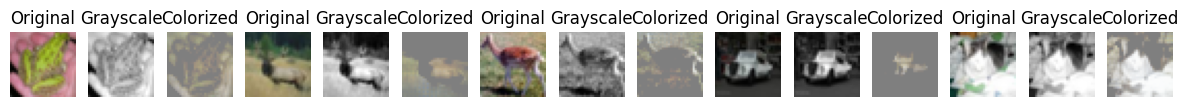

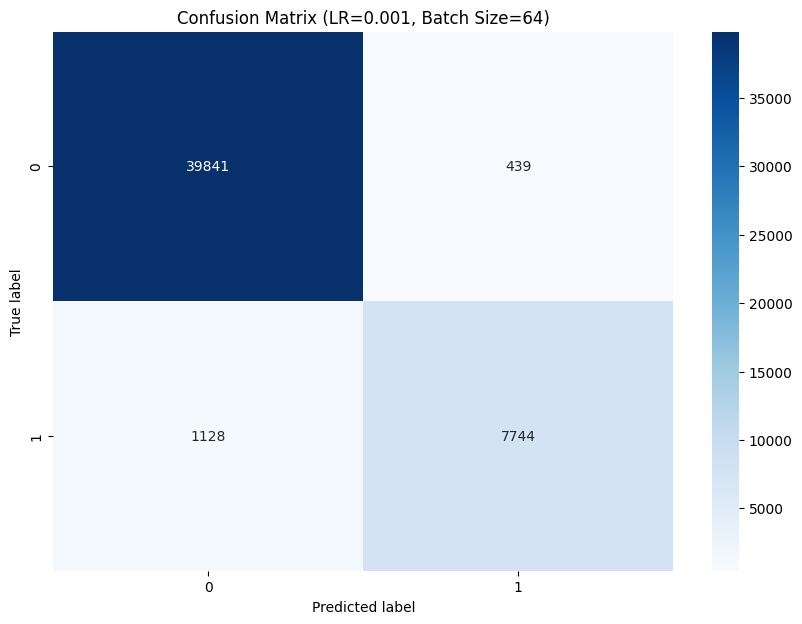

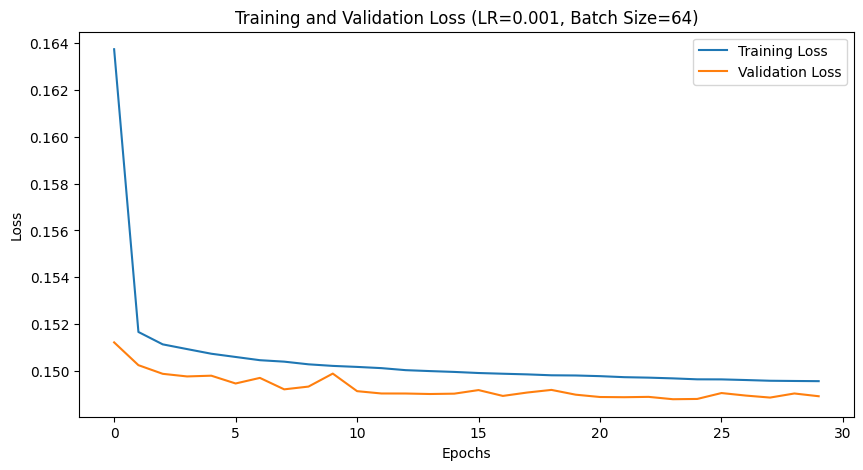

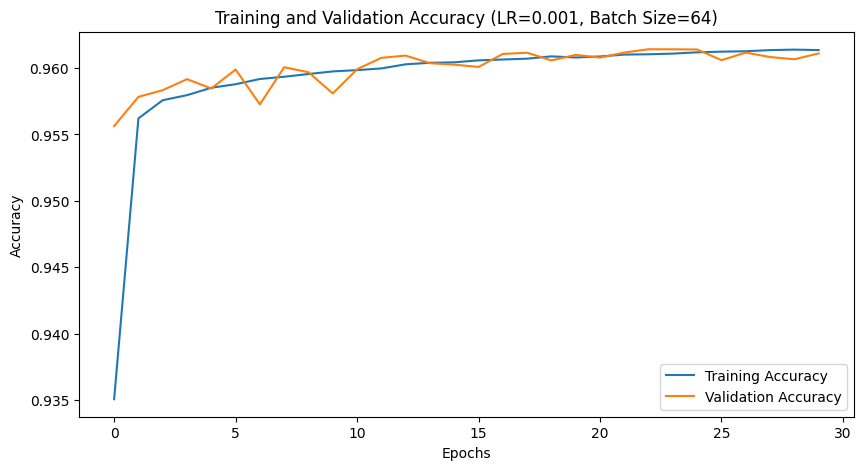


Training with Learning Rate: 0.0005, Batch Size: 32
Epoch [1/30], Batch [1/1250], Loss: 0.6625, 
Epoch [1/30], Batch [101/1250], Loss: 0.2204, 
Epoch [1/30], Batch [201/1250], Loss: 0.1932, 
Epoch [1/30], Batch [301/1250], Loss: 0.1812, 
Epoch [1/30], Batch [401/1250], Loss: 0.1749, 
Epoch [1/30], Batch [501/1250], Loss: 0.1703, 
Epoch [1/30], Batch [601/1250], Loss: 0.1669, 
Epoch [1/30], Batch [701/1250], Loss: 0.1649, 
Epoch [1/30], Batch [801/1250], Loss: 0.1634, 
Epoch [1/30], Batch [901/1250], Loss: 0.1624, 
Epoch [1/30], Batch [1001/1250], Loss: 0.1613, 
Epoch [1/30], Batch [1101/1250], Loss: 0.1603, 
Epoch [1/30], Batch [1201/1250], Loss: 0.1594, 
Epoch [1/30] completed in 35.48 seconds, Train Loss: 0.1591, Train Accuracy: 0.9449
Validation Loss: 0.1505, Validation Accuracy: 0.9565, PSNR: 8.26, SSIM: 0.0895
Epoch [2/30], Batch [1/1250], Loss: 0.1469, 
Epoch [2/30], Batch [101/1250], Loss: 0.1551, 
Epoch [2/30], Batch [201/1250], Loss: 0.1525, 
Epoch [2/30], Batch [301/1250], L

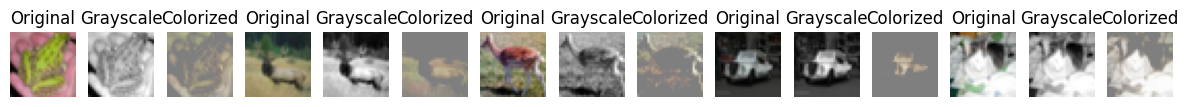

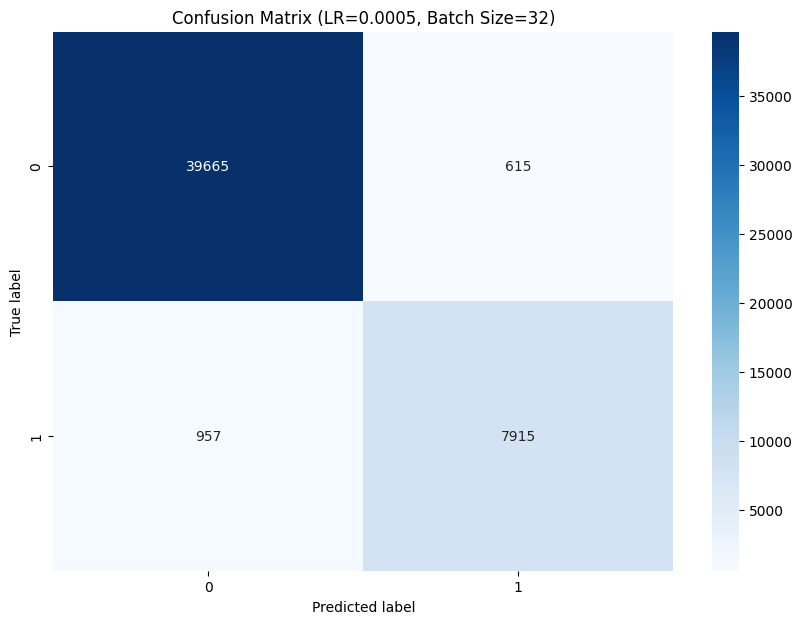

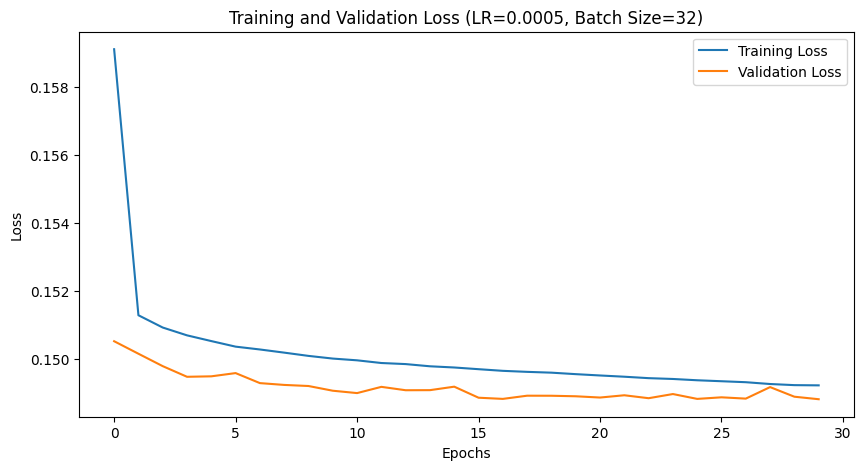

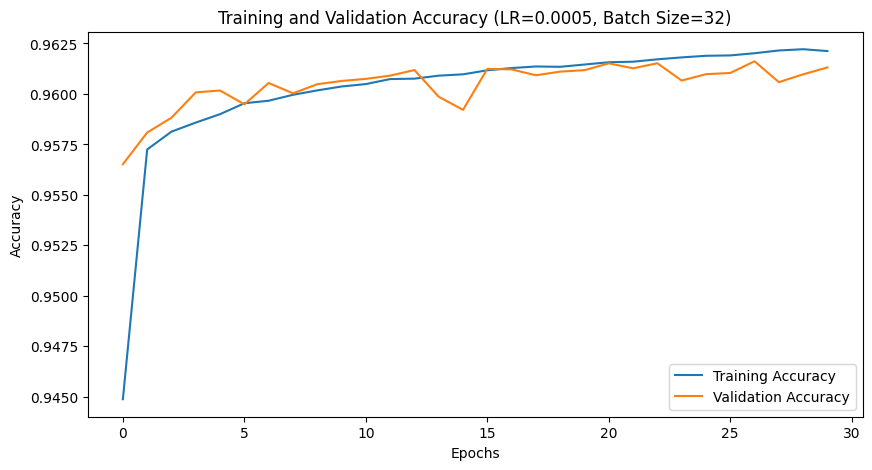


Training with Learning Rate: 0.0005, Batch Size: 64
Epoch [1/30], Batch [1/625], Loss: 0.5577, 
Epoch [1/30], Batch [101/625], Loss: 0.2024, 
Epoch [1/30], Batch [201/625], Loss: 0.1825, 
Epoch [1/30], Batch [301/625], Loss: 0.1745, 
Epoch [1/30], Batch [401/625], Loss: 0.1697, 
Epoch [1/30], Batch [501/625], Loss: 0.1664, 
Epoch [1/30], Batch [601/625], Loss: 0.1641, 
Epoch [1/30] completed in 34.38 seconds, Train Loss: 0.1637, Train Accuracy: 0.9365
Validation Loss: 0.1515, Validation Accuracy: 0.9545, PSNR: 8.21, SSIM: 0.0934
Epoch [2/30], Batch [1/625], Loss: 0.1624, 
Epoch [2/30], Batch [101/625], Loss: 0.1522, 
Epoch [2/30], Batch [201/625], Loss: 0.1518, 
Epoch [2/30], Batch [301/625], Loss: 0.1518, 
Epoch [2/30], Batch [401/625], Loss: 0.1514, 
Epoch [2/30], Batch [501/625], Loss: 0.1516, 
Epoch [2/30], Batch [601/625], Loss: 0.1517, 
Epoch [2/30] completed in 34.42 seconds, Train Loss: 0.1518, Train Accuracy: 0.9562
Validation Loss: 0.1503, Validation Accuracy: 0.9578, PSNR: 

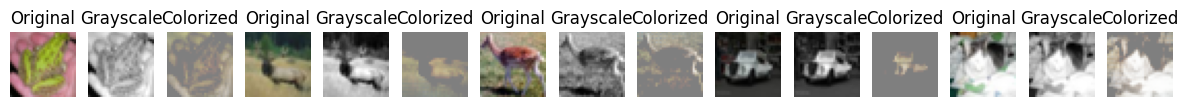

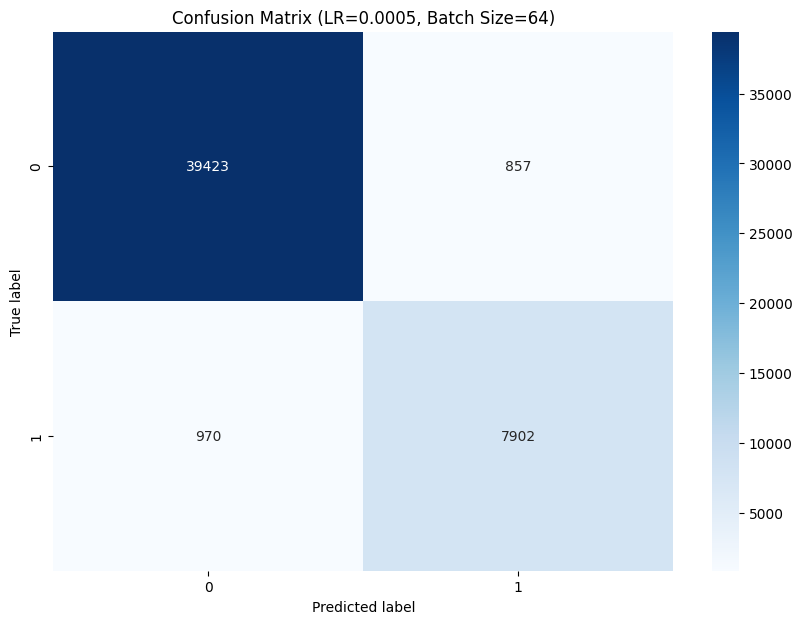

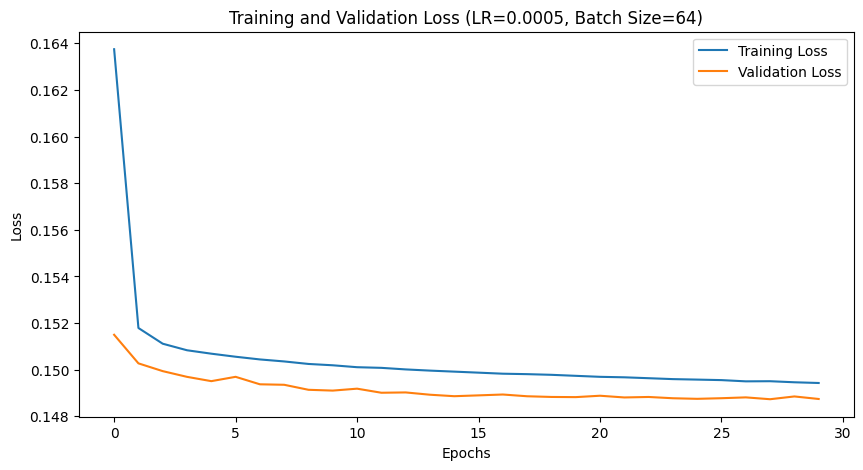

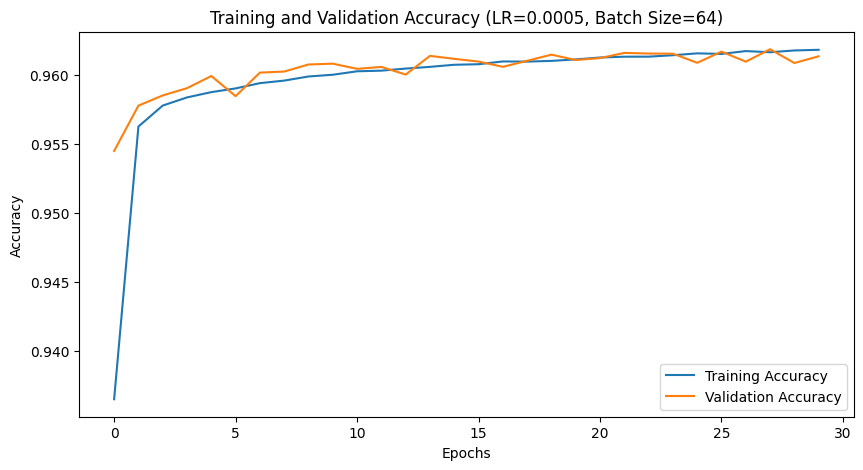


Training with Learning Rate: 0.0001, Batch Size: 32
Epoch [1/30], Batch [1/1250], Loss: 0.5642, 
Epoch [1/30], Batch [101/1250], Loss: 0.2597, 
Epoch [1/30], Batch [201/1250], Loss: 0.2178, 
Epoch [1/30], Batch [301/1250], Loss: 0.2007, 
Epoch [1/30], Batch [401/1250], Loss: 0.1908, 
Epoch [1/30], Batch [501/1250], Loss: 0.1850, 
Epoch [1/30], Batch [601/1250], Loss: 0.1809, 
Epoch [1/30], Batch [701/1250], Loss: 0.1778, 
Epoch [1/30], Batch [801/1250], Loss: 0.1750, 
Epoch [1/30], Batch [901/1250], Loss: 0.1729, 
Epoch [1/30], Batch [1001/1250], Loss: 0.1712, 
Epoch [1/30], Batch [1101/1250], Loss: 0.1698, 
Epoch [1/30], Batch [1201/1250], Loss: 0.1686, 
Epoch [1/30] completed in 36.09 seconds, Train Loss: 0.1679, Train Accuracy: 0.9344
Validation Loss: 0.1531, Validation Accuracy: 0.9524, PSNR: 8.18, SSIM: 0.0938
Epoch [2/30], Batch [1/1250], Loss: 0.1555, 
Epoch [2/30], Batch [101/1250], Loss: 0.1538, 
Epoch [2/30], Batch [201/1250], Loss: 0.1547, 
Epoch [2/30], Batch [301/1250], L

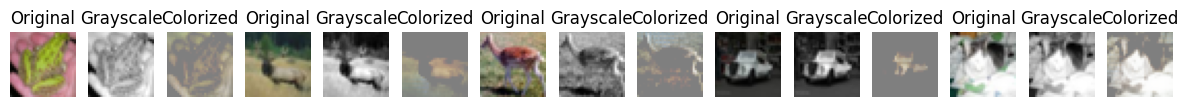

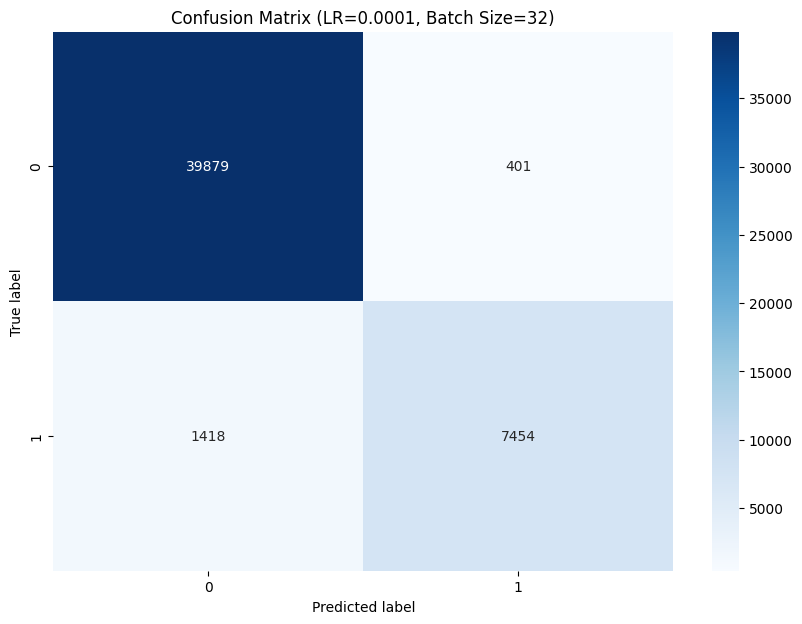

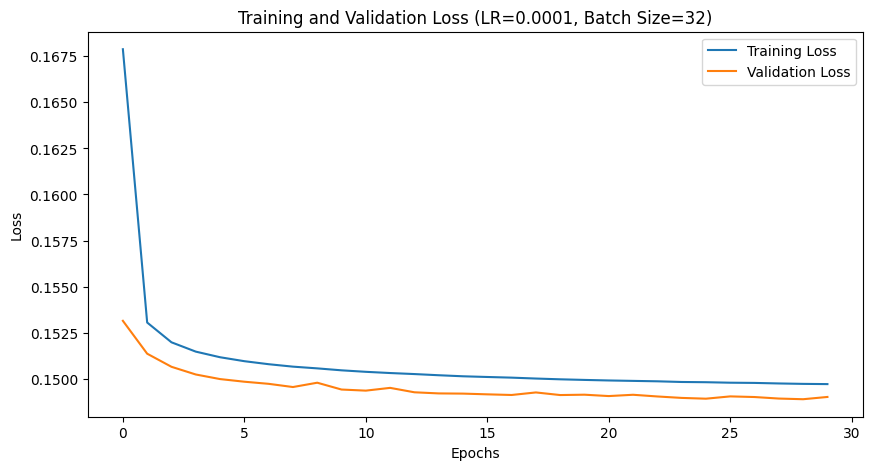

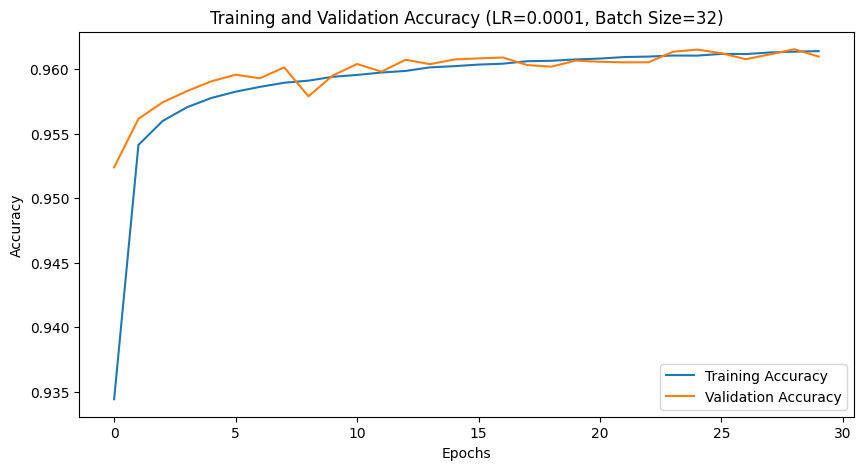


Training with Learning Rate: 0.0001, Batch Size: 64
Epoch [1/30], Batch [1/625], Loss: 0.5986, 
Epoch [1/30], Batch [101/625], Loss: 0.2624, 
Epoch [1/30], Batch [201/625], Loss: 0.2212, 
Epoch [1/30], Batch [301/625], Loss: 0.2038, 
Epoch [1/30], Batch [401/625], Loss: 0.1936, 
Epoch [1/30], Batch [501/625], Loss: 0.1868, 
Epoch [1/30], Batch [601/625], Loss: 0.1819, 
Epoch [1/30] completed in 34.61 seconds, Train Loss: 0.1810, Train Accuracy: 0.9197
Validation Loss: 0.1563, Validation Accuracy: 0.9456, PSNR: 8.07, SSIM: 0.1029
Epoch [2/30], Batch [1/625], Loss: 0.1546, 
Epoch [2/30], Batch [101/625], Loss: 0.1580, 
Epoch [2/30], Batch [201/625], Loss: 0.1564, 
Epoch [2/30], Batch [301/625], Loss: 0.1567, 
Epoch [2/30], Batch [401/625], Loss: 0.1561, 
Epoch [2/30], Batch [501/625], Loss: 0.1558, 
Epoch [2/30], Batch [601/625], Loss: 0.1554, 
Epoch [2/30] completed in 34.76 seconds, Train Loss: 0.1552, Train Accuracy: 0.9491
Validation Loss: 0.1526, Validation Accuracy: 0.9537, PSNR: 

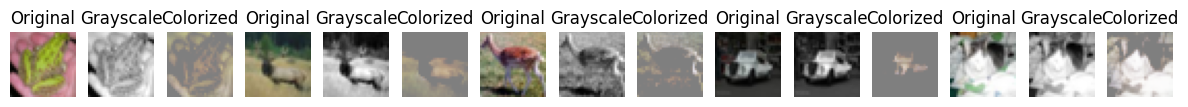

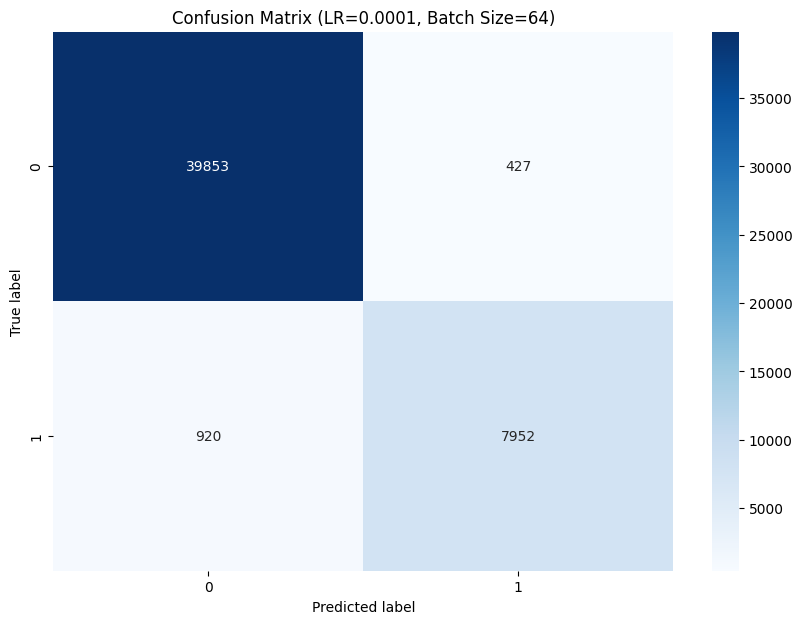

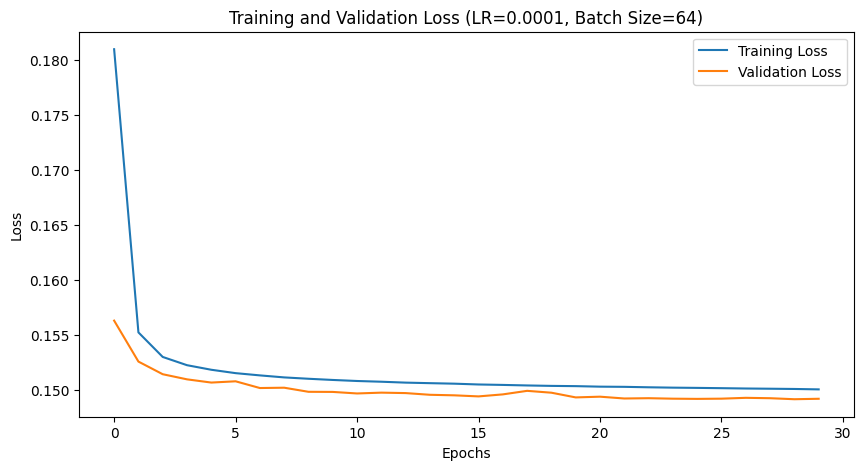

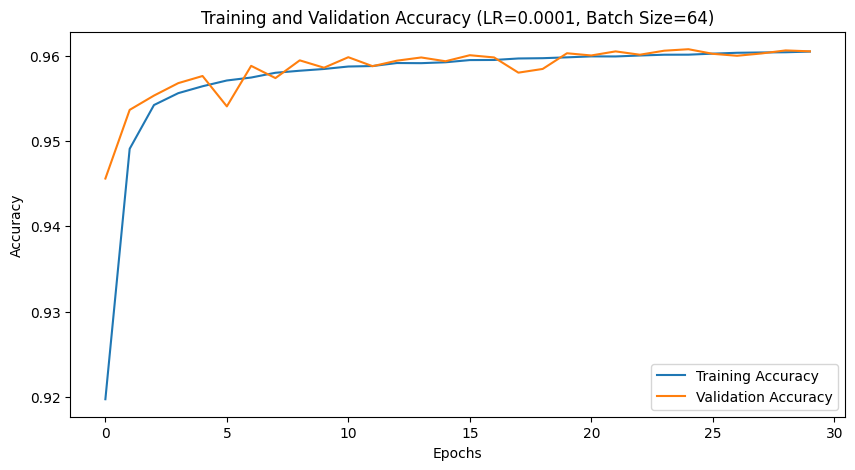

In [50]:
# Run experiments over the grid of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
        train_and_evaluate_model(lr, batch_size)